## Предсказание уровней воды на реке Амур

In [1]:
!pip install catboost shap
!git clone https://github.com/sberbank-ai/no_flood_with_ai_aij2020.git
!wget https://storage.yandexcloud.net/datasouls-ods/materials/c8b9bab3/datasets.zip
!unzip -o datasets.zip

     |████████████████████████████████| 66.3MB 61kB/s 
     |████████████████████████████████| 327kB 40.1MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463905 sha256=c4ac4c4740242c27832e227a92a650044ed65e19dfd9e591a856e8182380ef0f
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap
Cloning into 'no_flood_with_ai_aij2020'...
remote: Enumerating objects: 1151, done.
remote: Total 1151 (delta 0), reused 0 (delta 0), pack-reused 1151
Receiving objects: 100% (1151/1151), 141.81 MiB | 14.44 MiB/s, done.
Resolving deltas: 100% (692/692), done.
--2020-11-23 00:19:40--  https://storage.yandexcloud.net/datasouls-ods/materials/c8b9bab3/datasets.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200

In [2]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from catboost import CatBoostRegressor as cbr

from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV

In [3]:
# Путь до папки с данными
path_to_data = 'datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября 2019 года)

In [4]:
predict_period = ['2019-11-01', '2019-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

 Загрузка данных об уровнях воды на гидропостах.
 
 Датасет `daily.pkl` - собран из всех файлов `{номер_станции}_daily.csv` из папки 'datasets/', 
 номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате)

In [5]:
daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')

In [6]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [7]:
# Выбираем целевые гидрологические посты
station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]
daily = daily[daily['station_id'].isin(station_ids)]

Посмотрим как выглядит ряд для фиксированного `station_id`

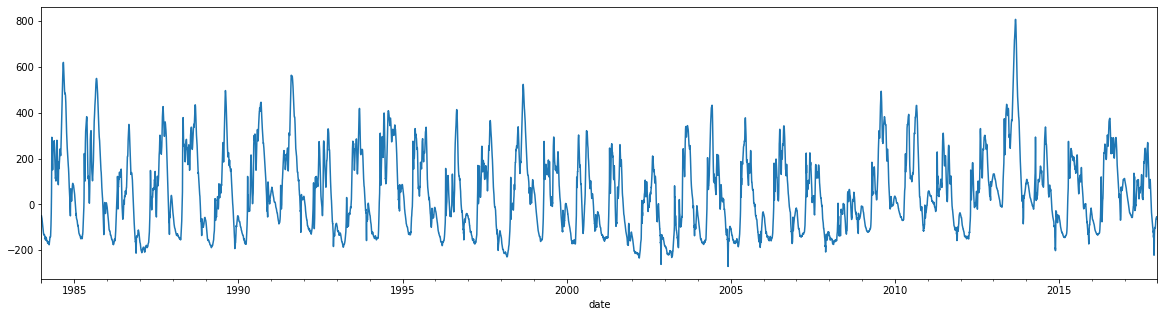

In [8]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле `datasets/hydro2019-20/new_data.csv`

In [9]:
nf = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';')

In [10]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотрим на графики новых данных:

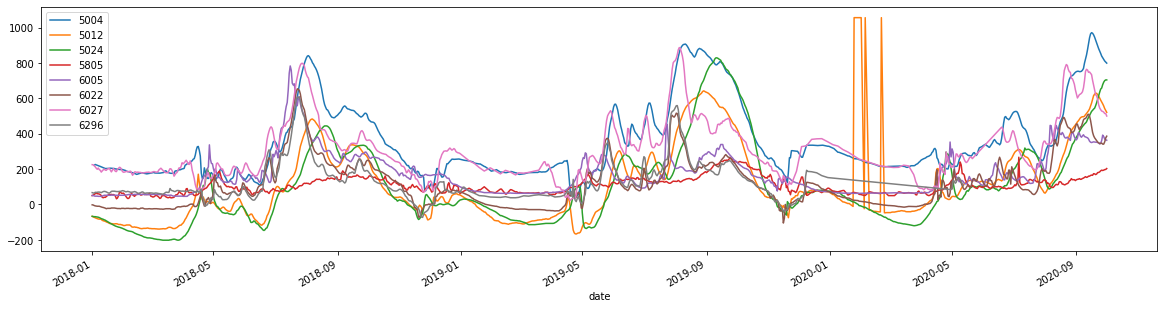

In [11]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

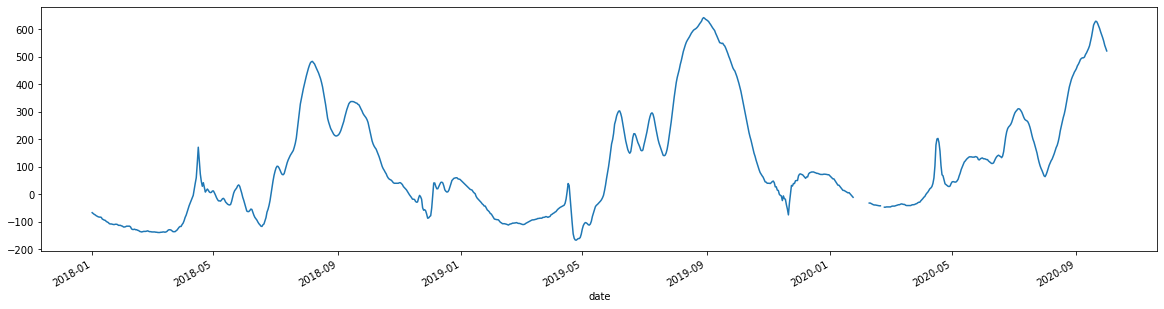

In [12]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты 

In [13]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

### Метеоданные 
Загрузка метеоданных, соответстующих целевым гидрологическим постам. 

Используемый датасет `s2m.pkl` - (station_to_meteo) - это таблица в которой номеру гидрологического поста поставлен в соответсвие номер ближайшей метеостанции, а так же указано расстояние до неё. Координаты гидрологических постов и метеостанций взяты из http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json

In [14]:
s2m = pd.read_pickle(path_to_data + 'processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


Пример таблицы с метеоданными

In [15]:
pd.read_csv(path_to_data + 'meteo/4263131.csv', sep=';').head()

def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку `meteo_id`, а номер гидрологического поста в `station_id`

In [16]:
meteo = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv(path_to_data + 'meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT+3, поэтому переведем их к Гринвичу

In [17]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.401762
3     -5.039252
6     -2.809799
9     -3.957306
12    -7.727059
15   -10.338852
18   -12.013950
21   -13.245664
Name: temperature_air, dtype: float64

Усреднение температурных признаков по (времени суток, дате)

In [18]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols

Получили датасет со средней ночной и дневной температурой воздуха и почвы за каждый день.

In [19]:
dmeteo.head()

day_temperature_air  ...  night_temperature_ground
station_id date                             ...                          
5004       1985-01-01              -17.900  ...                   -27.275
           1985-01-02              -16.775  ...                   -29.375
           1985-01-03              -18.975  ...                   -26.900
           1985-01-04              -19.150  ...                   -28.175
           1985-01-05              -21.200  ...                   -28.175

[5 rows x 4 columns]

Значения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [20]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [21]:
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [15, 15, 15, 15, 10, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

In [22]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

Присоединяем метеоданные к посуточным замерам уровней

In [23]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')
daily.shape

(93596, 13)

Создаем "календарные" признаки

In [24]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [25]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [26]:
# Цикл по количеству рассматриваемых лет
past = []
for y in range(1, 6):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [27]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

Создание признаков временного ряда

In [28]:
ndays = 20

In [29]:
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 0, -1):
    daily['ts_{}'.format(i)] = daily.groupby('station_id')['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))
# daily.drop('stage_max', axis=1, inplace=True)

Выкидываем строки в которых таргет NaN

In [30]:
daily = daily[daily['target'].notna()]

## Обучение

Для кросс-валидации использум деление выборки на __train__: до *f_day* i-го года; __test__: _predictperiod_ i-го года, где i пробегает 5 последних лет, имеющихся в тренировочной выборке.

In [31]:
# Генератор индексов для кросс-валидации
def train_test_fold(df, f_day, l_day):
    for year in [f_day.year - 5 + i for i in range(5)]:
        f = '{}-{}'.format(year, datetime.strftime(f_day, '%m-%d'))
        l = '{}-{}'.format(year, datetime.strftime(l_day, '%m-%d'))
        yield df.index[df.index < f], df.index[(df.index>=f)&(df.index<l)]

Реализация функции пошагового предсказания.
На вход подается:
- `model` - обученная модель
- `ts_data` - значения таргета за последние _ndays_ тренировочной выборки
- `test_data` - дополнительные признаки, в тестовый период (признаки не должны зависеть от значений, которые могут быть получены только в тестовый период. Поэтому, например, все погодные признаки сдвинуты на _predict_ndays_ вперед)
- `features` - список названий доп. признаков
- `n` - количество дней, на которые строится предказание

In [32]:
def steps_predict(model, ts_data, test_data, features, n):
    isfeat = len(features) > 0
    test_features = test_data[features].values
    if isfeat:
        data = np.r_[test_features[0], ts_data].reshape(1,-1)
    else:
        data = ts_data.reshape(1,-1)
    predict = []
    predict.append(model.predict(data)[0])

    for i in range(1, n):
        ts_data = np.r_[ts_data[1:], predict[i-1]]
        if isfeat:
            data = np.r_[test_features[i], ts_data].reshape(1,-1)
        else:
            data = ts_data.reshape(1,-1)
        predict.append(model.predict(data)[0])
    return np.array(predict)

In [33]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [34]:
def plot_predict(true, pred, station_id=None):
    plt.figure(figsize=(20, 5))
    plt.plot(true)
    plt.plot(pred)
    leg = ['true values', 'predict values']
    
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

Реализация собственной функции кросс-валидации модели. Разбиения строятся с помощью 
*train_test_fold(df, f_day, l_day)*. В качестве ошибки на валидационной выборке будем использовать метрику $MAE$

In [35]:
def cross_val(model, dataset, gen, target_name, features, lag, predict_ndays, 
              station_id, ts, eval_metric='wmae2', plotit=False):
    mae_list = []
    rmse_list = []
    wmae_list = []
    wmae2_list = []
    for i in range(5):
        train_idx, test_idx = next(gen)
        X_train = dataset.loc[train_idx].sort_index()
        X_test = dataset.loc[test_idx].sort_index()

        X = X_train[features + ts].copy()
        y = X_train[target_name]
        
        if eval_metric == 'wmae2':
            eval_metr = lambda x, y: ['wmae2', comp_wmae2(x, y, station_id), True]
        else:
            eval_metr = eval_metric
        model.fit(X, y)
        
        ts_data = X_train[target_name].values[-lag:]
        predict = steps_predict(model, ts_data, X_test, features, predict_ndays)
        if target_name == 'delta':
            predict = X_test['mean_by_date'].values + predict
        true = X_test[target_name].values
        mae = metrics(true, predict,station_id)
        mae_list.append(mae)

        if plotit:
            plot_predict(true, predict, station_id=station_id)
    res_table = pd.DataFrame([mae_list, rmse_list, wmae2_list], 
                        index=['MAE', 'RMSE', 'WMAE2'],
                        columns = ['fold{}'.format(i) for i in range(1, 6)])
    return res_table

Посмотрим на степень влияния дополнительных признаков на результат работы модели. Для этого воспользуемся библиотекой `shap` https://shap.readthedocs.io/en/latest/index.html 

Обучение LGBM с дефолтными параметрами и всеми доп. признакими.

In [36]:
for i in range(1, 6):
    daily[f"delta_past_10_{i}"] = daily[f"past_{i}_10"] - daily[f"past_{i}_10"]

In [37]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_lgb = cbr(random_state=33)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_lgb.fit(X_train, y_train)

Learning rate set to 0.061671
0:	learn: 167.2156578	total: 81.4ms	remaining: 1m 21s
1:	learn: 161.4666535	total: 103ms	remaining: 51.5s
2:	learn: 156.4886752	total: 125ms	remaining: 41.5s
3:	learn: 151.6052087	total: 146ms	remaining: 36.5s
4:	learn: 146.9558757	total: 167ms	remaining: 33.3s
5:	learn: 142.7896458	total: 189ms	remaining: 31.3s
6:	learn: 138.7113103	total: 214ms	remaining: 30.4s
7:	learn: 134.9246020	total: 236ms	remaining: 29.2s
8:	learn: 131.7367218	total: 257ms	remaining: 28.3s
9:	learn: 128.6601422	total: 279ms	remaining: 27.6s
10:	learn: 125.9052701	total: 302ms	remaining: 27.1s
11:	learn: 123.1880241	total: 325ms	remaining: 26.8s
12:	learn: 120.5102706	total: 347ms	remaining: 26.3s
13:	learn: 118.2716652	total: 368ms	remaining: 25.9s
14:	learn: 116.1465203	total: 390ms	remaining: 25.6s
15:	learn: 113.9779282	total: 412ms	remaining: 25.3s
16:	learn: 112.3367217	total: 441ms	remaining: 25.5s
17:	learn: 110.9647711	total: 466ms	remaining: 25.4s
18:	learn: 109.3159051	t

In [38]:
X_importance = X_train
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

In [39]:
X_train

,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,doy,past_1_0,past_1_1,past_1_2,past_1_3,past_1_4,past_1_5,past_1_6,past_1_7,past_1_8,past_1_9,past_1_10,past_2_0,past_2_1,past_2_2,past_2_3,past_2_4,past_2_5,past_2_6,past_2_7,past_2_8,past_2_9,past_2_10,past_3_0,past_3_1,past_3_2,past_3_3,past_3_4,past_3_5,past_3_6,past_3_7,past_3_8,past_3_9,past_3_10,past_4_0,past_4_1,past_4_2,past_4_3,past_4_4,past_4_5,past_4_6,past_4_7,past_4_8,past_4_9,past_4_10,past_5_0,past_5_1,past_5_2,past_5_3,past_5_4,past_5_5,past_5_6,past_5_7,past_5_8,past_5_9,past_5_10
1984-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,300.0,40.0,40.0,40.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,-41.0,-48.0,-53.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,56.0,47.0,39.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,-13.0,-18.0,-20.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-62.0,-63.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0
2019-10-28,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,301.0,40.0,40.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,20.0,-48.0,-53.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,-95.0,47.0,39.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,10.0,-18.0,-20.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-73.0,-63.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0
2019-10-29,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,302.0,40.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,20.0,16.0,-53.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,-95.0,-99.0,39.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,10.0,5.0,-20.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-73.0,-80.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0
2019-10-30,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,303.0,40.0,40.0,42.0,42.0,39.0,35.0,28.0,24.0,20.0,16.0,10.0,-57.0,-62.0,-67.0,-71.0,-73.0,-76.0,-83.0,-88.0,-95.0,-99.0,-102.0,29.0,35.0,35.0,39.0,45.0,42.0,27.0,17.0,10.0,5.0,-9.0,-25.0,-38.0,-42.0,-50.0,-55.0,-60.0,-62.0,-67.0,-73.0,-80.0,-75.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0,-93.0


Построения графика важности дополнительных признаков.

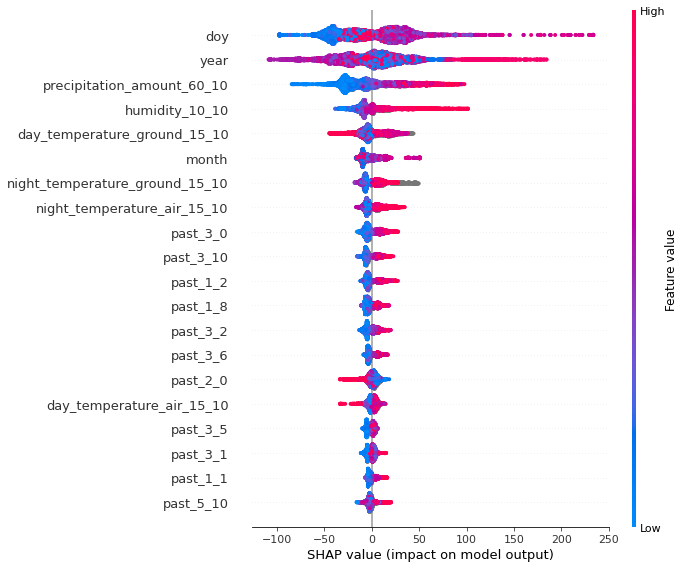

In [40]:
shap.summary_plot(shap_values, X_importance)

Из графика видно, что метеопризнаки довольно сильно влияют на целевое значение. Например, 
как и ожидалось, признак `precipitation_amount_60_10` - накопленные осадки за 60 дней, 10 дней назад при больших значениях дает положительный вклад в целевое значение, а при малых - отрицательный. Тот же эффект виден для `humidity_10_10` - накопленная влажность воздуха за 10 дней, 10 дней назад.

In [41]:
predict = model_lgb.predict(X_test)
true = y_test.values
metrics(true, predict, station_id)

9.272964932297963

###  GridSearch для поиска параметров модели

Простая функция для поиска трех основных параметров модели обучения:

In [46]:
def grid_search(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['n_estimators']:
        for lr in params['learning_rate']:
            #for nl in params['num_leaves']:
            model_lgb = cbr(n_estimators=ne,
                                            learning_rate=lr,
                                            #num_leaves=nl,
                                            random_state=33)
            gen = train_test_fold(sf, f_day, l_day)
            res = cross_val(model_lgb, df, gen, 'target', features, ndays, 
                            predict_ndays, station_id, ts, 'wmae2', plotit=False)
            metric = res.mean(axis=1)['MAE']
            if metric < best_metric:
                best_metric = metric
                best_params = dict(zip(params.keys(), [ne, lr]))
    return best_params

In [47]:
grid_params = {
    'n_estimators': [30, 70, 110],
    'learning_rate': [0.05, 0.1, 0.12],
    #'num_leaves': [27, 31, 37]
}

In [ ]:
model_params = {}
for station_id in station_ids:
    sf = daily.loc[station_id].copy()
    features = all_features
    model_params[station_id] = grid_search(sf, grid_params, features, ndays, predict_ndays, station_id, ts)

Выходные данные были обрезаны до нескольких последних строк (5000).
2:	learn: 117.1054521	total: 85.9ms	remaining: 1.92s
3:	learn: 105.3496328	total: 126ms	remaining: 2.08s
4:	learn: 94.5161480	total: 154ms	remaining: 2s
5:	learn: 85.2860988	total: 183ms	remaining: 1.95s
6:	learn: 77.3106440	total: 210ms	remaining: 1.89s
7:	learn: 69.7186434	total: 244ms	remaining: 1.89s
8:	learn: 63.2841887	total: 273ms	remaining: 1.85s
9:	learn: 57.4881024	total: 303ms	remaining: 1.81s
10:	learn: 52.7764075	total: 331ms	remaining: 1.77s
11:	learn: 48.3738311	total: 359ms	remaining: 1.74s
12:	learn: 44.6269347	total: 388ms	remaining: 1.7s
13:	learn: 41.3941062	total: 417ms	remaining: 1.67s
14:	learn: 38.6903709	total: 445ms	remaining: 1.63s
15:	learn: 36.5492217	total: 479ms	remaining: 1.62s
16:	learn: 34.5682265	total: 506ms	remaining: 1.58s
17:	learn: 32.9428238	total: 533ms	remaining: 1.54s
18:	learn: 31.3865922	total: 567ms	remaining: 1.52s
19:	learn: 30.2096636	total: 596ms	remaining: 1.49s
20:	l

### Результаты
В следующей ячейки собирается таблица с результатами предсказаний `sample_submission`. 

Построены графики с предсказанными и настоящими значениями и выведено значение метрики для каждого гидрологического поста.

0:	learn: 125.7754604	total: 29.6ms	remaining: 3.23s
1:	learn: 115.1839371	total: 66.3ms	remaining: 3.58s
2:	learn: 105.8415881	total: 96.6ms	remaining: 3.45s
3:	learn: 97.3442721	total: 125ms	remaining: 3.32s
4:	learn: 89.3019592	total: 154ms	remaining: 3.23s
5:	learn: 82.0329103	total: 184ms	remaining: 3.18s
6:	learn: 75.7817515	total: 215ms	remaining: 3.16s
7:	learn: 69.9791469	total: 246ms	remaining: 3.14s
8:	learn: 64.7611767	total: 275ms	remaining: 3.08s
9:	learn: 60.2043141	total: 303ms	remaining: 3.03s
10:	learn: 56.1748037	total: 331ms	remaining: 2.98s
11:	learn: 52.5906368	total: 360ms	remaining: 2.94s
12:	learn: 49.3423695	total: 392ms	remaining: 2.92s
13:	learn: 46.5511256	total: 424ms	remaining: 2.91s
14:	learn: 43.9102232	total: 455ms	remaining: 2.88s
15:	learn: 41.7131318	total: 486ms	remaining: 2.85s
16:	learn: 39.7591266	total: 517ms	remaining: 2.83s
17:	learn: 38.0518710	total: 545ms	remaining: 2.78s
18:	learn: 36.4230825	total: 572ms	remaining: 2.74s
19:	learn: 35.00

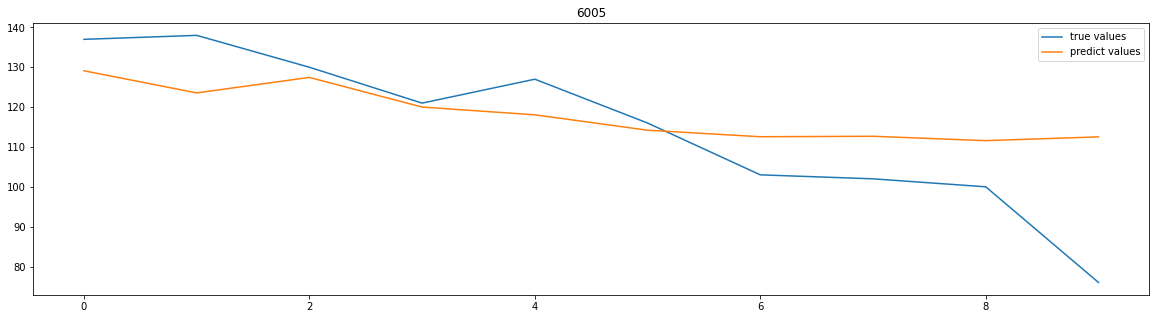

0:	learn: 123.2315624	total: 28.3ms	remaining: 3.09s
1:	learn: 112.4172370	total: 57.6ms	remaining: 3.11s
2:	learn: 102.9921951	total: 85.8ms	remaining: 3.06s
3:	learn: 94.0664454	total: 115ms	remaining: 3.04s
4:	learn: 86.0794190	total: 149ms	remaining: 3.12s
5:	learn: 78.9953663	total: 179ms	remaining: 3.1s
6:	learn: 72.4455474	total: 207ms	remaining: 3.05s
7:	learn: 66.4035455	total: 238ms	remaining: 3.04s
8:	learn: 61.0087204	total: 269ms	remaining: 3.02s
9:	learn: 56.1682590	total: 300ms	remaining: 3s
10:	learn: 51.9640551	total: 336ms	remaining: 3.02s
11:	learn: 48.2057616	total: 364ms	remaining: 2.98s
12:	learn: 44.6859357	total: 393ms	remaining: 2.94s
13:	learn: 41.6084117	total: 422ms	remaining: 2.89s
14:	learn: 38.8080584	total: 453ms	remaining: 2.87s
15:	learn: 36.4899164	total: 480ms	remaining: 2.82s
16:	learn: 34.4056239	total: 507ms	remaining: 2.78s
17:	learn: 32.5274320	total: 536ms	remaining: 2.74s
18:	learn: 30.8675953	total: 564ms	remaining: 2.7s
19:	learn: 29.4443673

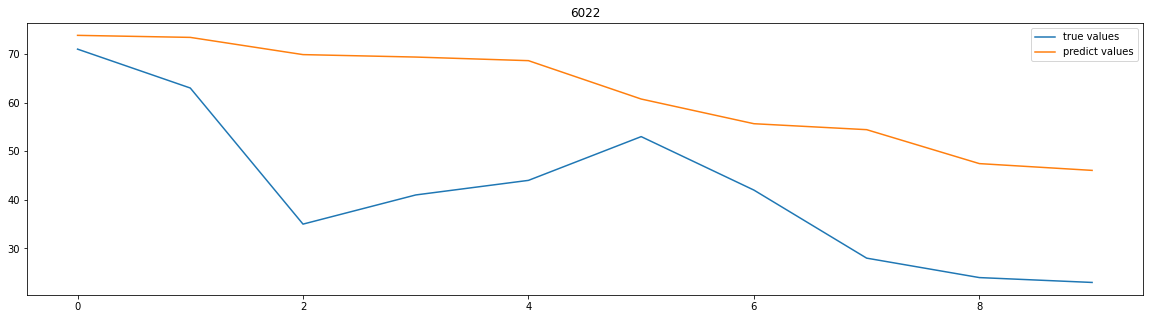

0:	learn: 149.0016468	total: 28.9ms	remaining: 3.15s
1:	learn: 136.1852292	total: 63.5ms	remaining: 3.43s
2:	learn: 124.2861750	total: 92.5ms	remaining: 3.3s
3:	learn: 114.0788285	total: 122ms	remaining: 3.23s
4:	learn: 104.1858071	total: 150ms	remaining: 3.15s
5:	learn: 95.6149048	total: 181ms	remaining: 3.13s
6:	learn: 87.9049489	total: 209ms	remaining: 3.07s
7:	learn: 80.4628549	total: 240ms	remaining: 3.06s
8:	learn: 73.9895781	total: 269ms	remaining: 3.02s
9:	learn: 68.1897669	total: 298ms	remaining: 2.98s
10:	learn: 63.0820229	total: 325ms	remaining: 2.93s
11:	learn: 58.4311296	total: 354ms	remaining: 2.89s
12:	learn: 54.2080594	total: 385ms	remaining: 2.87s
13:	learn: 50.5759197	total: 417ms	remaining: 2.86s
14:	learn: 47.2845130	total: 450ms	remaining: 2.85s
15:	learn: 44.2734024	total: 480ms	remaining: 2.82s
16:	learn: 41.6045649	total: 509ms	remaining: 2.78s
17:	learn: 39.4015366	total: 537ms	remaining: 2.75s
18:	learn: 37.3819963	total: 565ms	remaining: 2.71s
19:	learn: 35.6

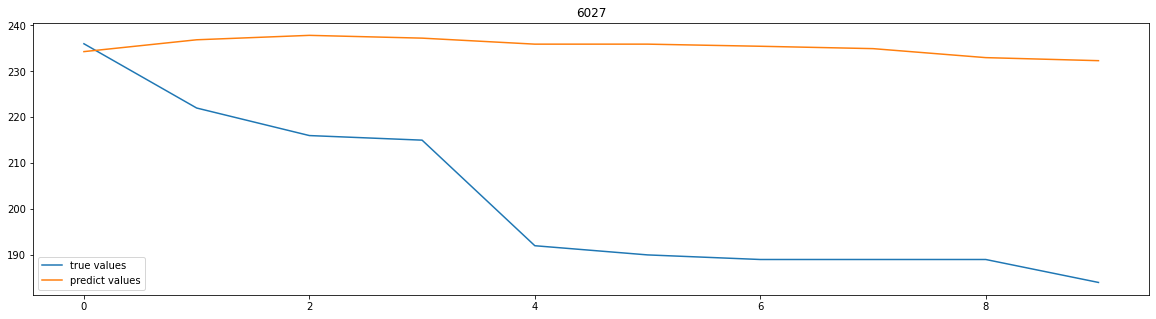

0:	learn: 169.7682205	total: 29.2ms	remaining: 3.18s
1:	learn: 154.8989284	total: 66.4ms	remaining: 3.58s
2:	learn: 141.5990433	total: 94.6ms	remaining: 3.37s
3:	learn: 129.5260882	total: 123ms	remaining: 3.26s
4:	learn: 118.5146235	total: 152ms	remaining: 3.2s
5:	learn: 108.4399173	total: 190ms	remaining: 3.29s
6:	learn: 98.9461145	total: 219ms	remaining: 3.22s
7:	learn: 90.2379200	total: 251ms	remaining: 3.2s
8:	learn: 82.5091926	total: 281ms	remaining: 3.15s
9:	learn: 75.5851462	total: 309ms	remaining: 3.09s
10:	learn: 69.5492020	total: 340ms	remaining: 3.06s
11:	learn: 64.1023166	total: 370ms	remaining: 3.02s
12:	learn: 59.0804617	total: 400ms	remaining: 2.98s
13:	learn: 54.7881497	total: 430ms	remaining: 2.95s
14:	learn: 50.9813787	total: 463ms	remaining: 2.93s
15:	learn: 47.4609172	total: 492ms	remaining: 2.89s
16:	learn: 44.5205872	total: 523ms	remaining: 2.86s
17:	learn: 41.7458409	total: 551ms	remaining: 2.81s
18:	learn: 39.3337798	total: 579ms	remaining: 2.77s
19:	learn: 37.2

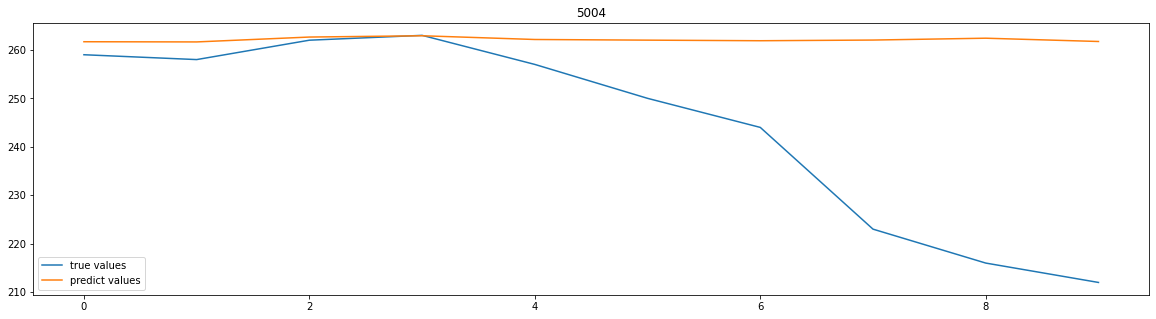

0:	learn: 157.8897565	total: 28.7ms	remaining: 3.12s
1:	learn: 143.2593246	total: 57.2ms	remaining: 3.09s
2:	learn: 130.3883374	total: 85.9ms	remaining: 3.06s
3:	learn: 118.8011877	total: 115ms	remaining: 3.04s
4:	learn: 108.1756412	total: 146ms	remaining: 3.06s
5:	learn: 98.6579262	total: 181ms	remaining: 3.14s
6:	learn: 90.3827435	total: 211ms	remaining: 3.11s
7:	learn: 82.2547398	total: 246ms	remaining: 3.13s
8:	learn: 75.2555570	total: 274ms	remaining: 3.08s
9:	learn: 68.9367545	total: 303ms	remaining: 3.03s
10:	learn: 63.4007617	total: 332ms	remaining: 2.99s
11:	learn: 58.4054670	total: 361ms	remaining: 2.95s
12:	learn: 53.6543162	total: 397ms	remaining: 2.96s
13:	learn: 49.7458977	total: 427ms	remaining: 2.93s
14:	learn: 46.0966440	total: 461ms	remaining: 2.92s
15:	learn: 42.8229908	total: 492ms	remaining: 2.89s
16:	learn: 39.9379083	total: 521ms	remaining: 2.85s
17:	learn: 37.2453002	total: 549ms	remaining: 2.8s
18:	learn: 34.8445240	total: 578ms	remaining: 2.77s
19:	learn: 32.8

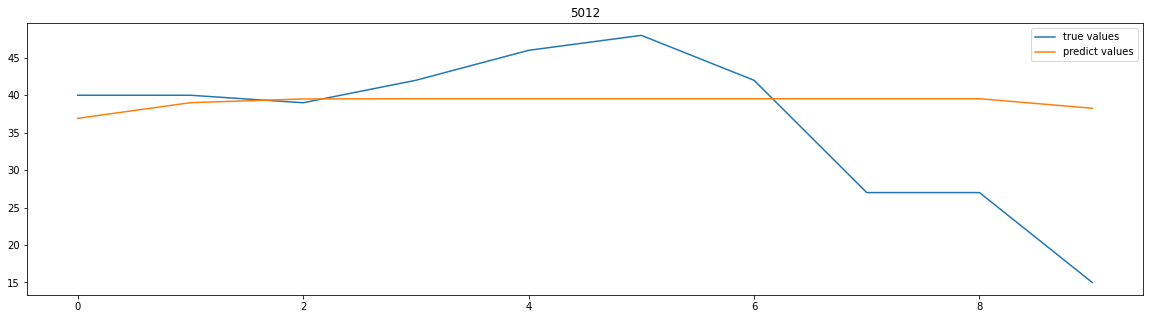

0:	learn: 178.3201953	total: 28.7ms	remaining: 1.98s
1:	learn: 162.1724193	total: 57.4ms	remaining: 1.95s
2:	learn: 147.5741557	total: 87.2ms	remaining: 1.95s
3:	learn: 134.5764493	total: 115ms	remaining: 1.9s
4:	learn: 122.6935305	total: 144ms	remaining: 1.87s
5:	learn: 112.0460457	total: 172ms	remaining: 1.83s
6:	learn: 102.1363623	total: 201ms	remaining: 1.81s
7:	learn: 93.1305419	total: 236ms	remaining: 1.82s
8:	learn: 85.0809935	total: 265ms	remaining: 1.79s
9:	learn: 78.0143433	total: 295ms	remaining: 1.77s
10:	learn: 71.4916164	total: 329ms	remaining: 1.76s
11:	learn: 65.7599209	total: 359ms	remaining: 1.74s
12:	learn: 60.3207141	total: 390ms	remaining: 1.71s
13:	learn: 55.6079561	total: 419ms	remaining: 1.68s
14:	learn: 51.4582547	total: 451ms	remaining: 1.65s
15:	learn: 47.6859171	total: 479ms	remaining: 1.62s
16:	learn: 44.4327933	total: 507ms	remaining: 1.58s
17:	learn: 41.4209130	total: 536ms	remaining: 1.55s
18:	learn: 38.6249156	total: 565ms	remaining: 1.52s
19:	learn: 36

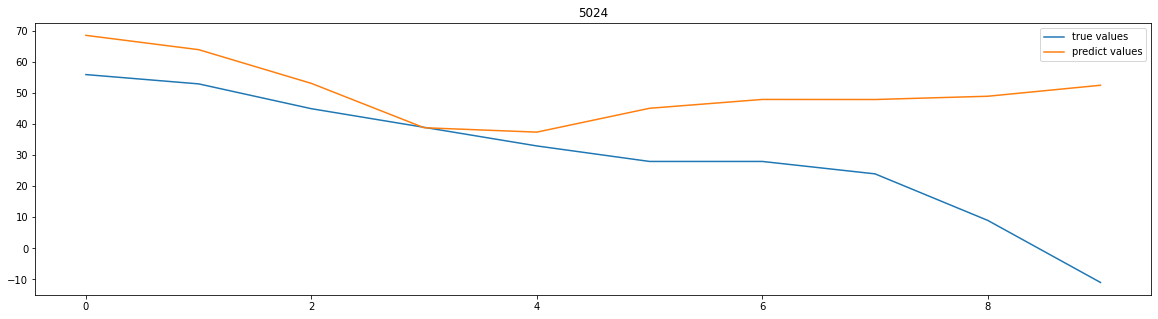

0:	learn: 39.6966181	total: 32.7ms	remaining: 2.26s
1:	learn: 36.3550780	total: 61.6ms	remaining: 2.09s
2:	learn: 33.4414634	total: 89.8ms	remaining: 2s
3:	learn: 30.7470571	total: 118ms	remaining: 1.95s
4:	learn: 28.3643259	total: 147ms	remaining: 1.91s
5:	learn: 26.1632452	total: 175ms	remaining: 1.86s
6:	learn: 24.2023083	total: 203ms	remaining: 1.82s
7:	learn: 22.4054028	total: 231ms	remaining: 1.79s
8:	learn: 20.8033206	total: 263ms	remaining: 1.78s
9:	learn: 19.4477656	total: 292ms	remaining: 1.75s
10:	learn: 18.1660256	total: 328ms	remaining: 1.76s
11:	learn: 17.0651301	total: 362ms	remaining: 1.75s
12:	learn: 16.0672537	total: 390ms	remaining: 1.71s
13:	learn: 15.2767857	total: 420ms	remaining: 1.68s
14:	learn: 14.4903661	total: 448ms	remaining: 1.64s
15:	learn: 13.8046253	total: 481ms	remaining: 1.62s
16:	learn: 13.2303709	total: 509ms	remaining: 1.59s
17:	learn: 12.7209772	total: 538ms	remaining: 1.55s
18:	learn: 12.2759877	total: 568ms	remaining: 1.52s
19:	learn: 11.9426423	

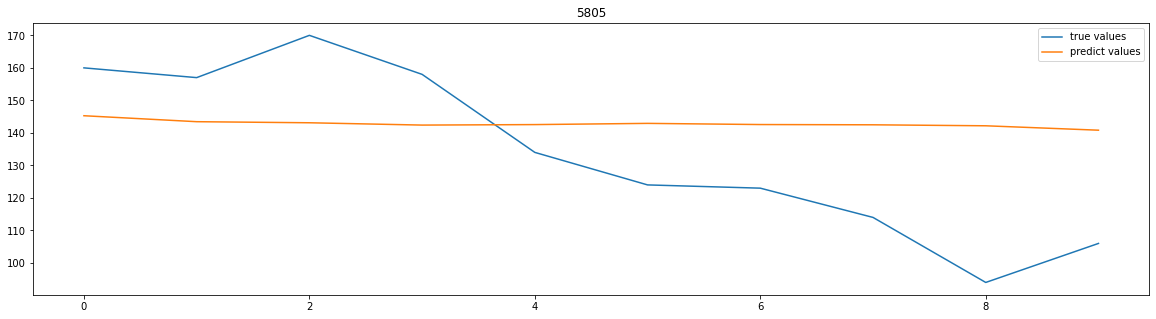

In [ ]:
from catboost import CatBoostRegressor, Pool, sum_models

train_pool = Pool(X_train, 
                  y_train)
models = []
for i in range(5):
    model = CatBoostRegressor(iterations=100, 
                               random_seed=i)
    model.fit(train_pool)
    models.append(model)

models_avrg = sum_models(models, 
                         weights=[1.0/len(models)] * len(models))


sample_submission = pd.DataFrame(index=pd.date_range(f_day, l_day - timedelta(1)))
lgbm_metrics = {}
for key in model_params:
    station_id = int(key)
    params = model_params[key]

    sf = daily.loc[int(key)]
    X_train = sf.loc[sf.index < f_day, features + ts]
    y_train = sf.loc[sf.index < f_day, 'target']
    X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
    y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']

    train_pool = Pool(X_train, y_train)  
    validate_pool = Pool(X_test, y_test)

    models = []
    for i in range(5):
        model = cbr(n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],
                              random_state=i)
        
        model.fit(train_pool, eval_set=validate_pool)
        models.append(model)

    models_avrg = sum_models(models, weights=[1.0/len(models)] * len(models))

    ts_data = y_train.values[-ndays:]
    predict = steps_predict(models_avrg, ts_data, X_test, features, predict_ndays)
    sample_submission[key] = predict # запись результата в таблицу
    mae = metrics(y_test.values, predict, station_id)
    lgbm_metrics[station_id] = [mae]
    print(station_id, ' MAE: ', mae)
    plot_predict(y_test.values, predict, station_id)

Сформируем файл с результатом

In [ ]:
sample_submission

,6005,6022,6027,5004,5012,5024,5805
2019-11-01,129.113355,73.834017,234.289159,261.683144,36.916518,68.642885,145.277097
2019-11-02,123.559821,73.415786,236.866196,261.643361,39.008072,64.032849,143.444209
2019-11-03,127.444590,69.872576,237.831340,262.650029,39.504860,53.159953,143.112497
2019-11-04,120.007306,69.369812,237.224120,262.916966,39.538941,38.868239,142.400989
2019-11-05,118.062192,68.628065,235.915048,262.145805,39.538941,37.449916,142.553563
2019-11-06,114.198169,60.734013,235.916249,262.011398,39.538941,45.137059,142.927262
2019-11-07,112.561991,55.656703,235.455193,261.890411,39.538941,47.985202,142.566889
2019-11-08,112.677329,54.431445,234.938023,262.030259,39.538941,47.966121,142.487760
2019-11-09,111.580214,47.448926,232.978499,262.412141,39.538941,49.015969,142.184116
2019-11-10,112.523597,46.054438,232.315649,261.733467,38.266460,52.554699,140.829487


Сохранение результата

In [ ]:
sample_submission.to_csv('sample_submission.csv')